In [13]:
import sys
sys.path.append('C:/Users/dinle/Code/Learning/Py_Code/AI_Learning/NodeLayer')
sys.path.append('C:/Users/dinle/Code/Learning/Py_Code/AI_Learning/mnist')
sys.path.append('/Users/leo/Code/Learning/Py_Code/AI_Learning/NodeLayer')
sys.path.append('/Users/leo/Code/Learning/Py_Code/AI_Learning/mnist')
from NodeLayer.network.multi_layer_net_extend import MultiLayerNetExtend as mt1
from mnist.common.multi_layer_net_extend import MultiLayerNetExtend as mt2
from NodeLayer.network.simple_convnet import SimpleConvNet as cv1
from mnist.ch07.simple_convnet import SimpleConvNet as cv2
import matplotlib.pyplot as plt
from mnist.dataset.mnist import load_mnist
from mnist.common.util import smooth_curve
from mnist.common.optimizer import *
import numpy as np
import time


In [14]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
test_size = x_test.shape[0]
batch_size = 128
max_iterations = 1000
mi = np.arange(max_iterations)
optimizer = AdaGrad()

In [15]:
def test(test_list):
    networks = {}
    train_acc = {}
    train_loss = {}
    test_acc = {}
    test_loss = {}
    optimizer = {}
    time_record = {}

    for key in test_list.keys():
        # 기록 리스트 생성
        train_acc[key] = []
        train_loss[key] = []
        test_acc[key] = []
        test_loss[key] = []
        time_record[key] = 0

        # nSigmoid 경우 파라미터
        # key == 'nSigmoid_8' -> act = nSigmoid, threshold = 8
        model = test_list[key]['model']
        lr = test_list[key]['lr']


        # 네트워크와 optimizer 생성
        if model == 'cv1':
            networks[key] = cv1()
        elif model == 'cv':
            networks[key] = cv2()
        elif model == 'mt1':
            act = test_list[key]['act']
            std = test_list[key]['std']
            dr = test_list[key]['dr']
            bn = test_list[key]['bn']
            do = False
            if dr is not None:
                do = True
            networks[key] = mt1(input_size=784, hidden_size_list=[100, 100, 100, 100],
                output_size=10, use_dropout=do, dropout_ration=dr, activation=act, weight_init_std=std,  use_batchnorm=bn)
        else:
            act = test_list[key]['act']
            std = test_list[key]['std']
            dr = test_list[key]['dr']
            bn = test_list[key]['bn']
            do = False
            if dr is not None:
                do = True
            networks[key] = mt2(input_size=784, hidden_size_list=[100, 100, 100, 100],
                output_size=10, use_dropout=do, dropout_ration=dr, activation=act, weight_init_std=std,  use_batchnorm=bn)
        optimizer[key] = AdaGrad(lr)

    # 학습
    for i in range(max_iterations):

        # mini-batch train
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # mini-batch test
        batch_mask_t = np.random.choice(test_size, batch_size)
        x_batch_t = x_test[batch_mask_t]
        t_batch_t = t_test[batch_mask_t]

        if i % 100 == 0:
            print( "===========" + "iteration:" + str(i) + "===========")

        # 학습
        for key in test_list.keys():
            start = time.time()
            if test_list[key]['model'].startswith('cv'):
                x_batch = x_batch.reshape(-1, 1, 28, 28)
                x_batch_t = x_batch_t.reshape(-1, 1, 28, 28)
            # 학습
            grads = networks[key].gradient(x_batch, t_batch)
            optimizer[key].update(networks[key].params, grads)

            # 기록
            train_acc[key].append(networks[key].accuracy(x_batch, t_batch))
            train_loss[key].append(networks[key].loss(x_batch, t_batch))
            test_acc[key].append(networks[key].accuracy(x_batch_t, t_batch_t))
            test_loss[key].append(networks[key].loss(x_batch_t, t_batch_t))


            # 100회마다 경과 출력
            if i % 100 == 0:
                # print(key + " loss:" + str(acc))
                t_loss = networks[key].loss(x_batch_t, t_batch_t)
                end = time.time()
                time_record[key] += (end-start)
                print(key + " loss:" + str(t_loss) + " time:" + str(time_record[key]))
            else:
                end = time.time()
                time_record[key] += (end-start)

    return train_acc, train_loss, test_acc, test_loss


def plot(label, datas, t_list, *y_lim):
    for key in t_list:
        plt.plot(mi, smooth_curve(datas[key]), markevery=50, label=key)
    plt.xlabel("iterations")
    plt.ylabel(label)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend()
    plt.show()

In [16]:
test_list = {
             'Node':
                 {'model':'mt1','act':'relu','std':'he','dr':None,'bn':False,'lr':0.01},
             'Node_BN':
                 {'model':'mt1','act':'relu','std':'he','dr':None,'bn':True,'lr':0.01},
              'Text':
                {'model':'mt2','act':'relu','std':'he','dr':None,'bn':False,'lr':0.01},
            'Text_BN':
                {'model':'mt2','act':'relu','std':'he','dr':None,'bn':True,'lr':0.01},
             }



train_acc, train_loss, test_acc, test_loss = test(test_list)

===========iteration:0===========
Node loss:2.5185991590636743 time:0.0208892822265625
Node_BN loss:12.310238416245141 time:0.02047276496887207
Text loss:2.2677394646635802 time:0.016322851181030273
Text_BN loss:11.489519387960748 time:0.01926279067993164
===========iteration:100===========
Node loss:0.3108879316154092 time:1.3553922176361084
Node_BN loss:0.2726150832993977 time:1.785323143005371
Text loss:0.3172985818009447 time:1.1439754962921143
Text_BN loss:0.2459174222351131 time:1.416778564453125
===========iteration:200===========
Node loss:0.24627343368420987 time:2.552950859069824
Node_BN loss:0.18597143911065514 time:3.331448793411255
Text loss:0.21858039559585715 time:2.1732966899871826
Text_BN loss:0.2118148201841854 time:2.634409189224243
===========iteration:300===========
Node loss:0.17804262227701295 time:3.75435471534729
Node_BN loss:0.19755133009066825 time:4.898467063903809
Text loss:0.2156285957205728 time:3.216155529022217
Text_BN loss:0.15704897086596442 time:3.84

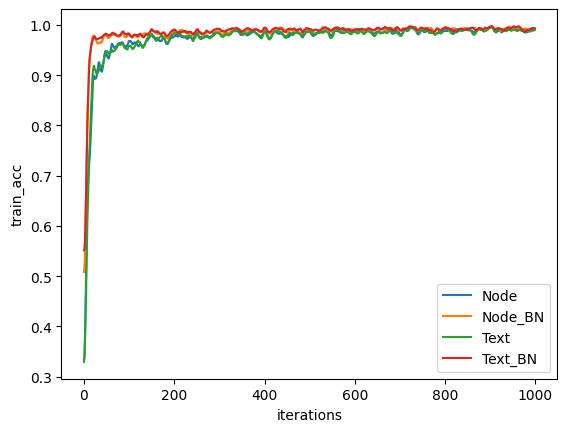

In [17]:
plot('train_acc', train_acc, test_list)

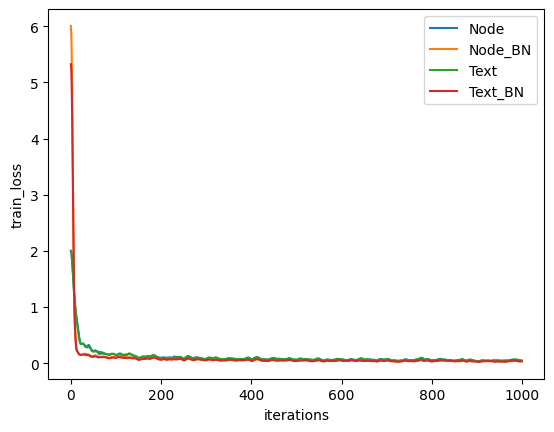

In [18]:
plot('train_loss', train_loss, test_list)